In [1]:
%matplotlib inline
import pandas
import os
import collections
import numpy

from src.train_test import find_files, parse_dates

def load_series(files, add_file_number=False, resample_interval=None, date_cols=True):
    data = [pandas.read_csv(f, parse_dates=date_cols, date_parser=parse_dates, index_col=0) for f in files]

    if resample_interval:
        data = [d.resample(resample_interval).mean() for d in data]

    if add_file_number:
        for i, year_data in enumerate(data):
            year_data["file_number"] = i

    return pandas.concat(data)

def rate_columns(data):
    """Rate columns by mean and stddev"""
    return collections.Counter({c: data[c].mean() + data[c].std() for c in data.columns}).most_common()

def get_average_interval(time_indexed_data):
    return (time_indexed_data.index.max() - time_indexed_data.index.min()) / time_indexed_data.shape[0]

Using Theano backend.


In [2]:
# load all data for subsequent cells
path = "data/v2/all_data/"
power_data = load_series(find_files("data/v2/train_set/", "power"), resample_interval="1H")
longterm_data = load_series(find_files(path, "ltdata"))
event_data = load_series(find_files(path, "evtf"))
dmop_data = load_series(find_files(path, "dmop"))
saa_data = load_series(find_files(path, "saaf"))
ftl_data = load_series(find_files(path, "ftl"), date_cols=["utb_ms", "ute_ms"])

In [55]:
d = [["Power (resampled)", get_average_interval(power_data)],
    ["Long term", get_average_interval(longterm_data)],
    ["Event", get_average_interval(event_data)],
    ["DMOP", get_average_interval(dmop_data)],
    ["SAAF", get_average_interval(saa_data)],
    ["FTL", get_average_interval(ftl_data)]]
pandas.DataFrame(d, columns=["Data set", "Average time interval"])

,Data set,Average time interval
0,Power (resampled),00:59:59.927219
1,Long term,23:59:28.558951
2,Event,00:12:01.389474
3,DMOP,00:06:08.299687
4,SAAF,00:00:51.110708
5,FTL,00:59:07.295944


In [38]:
event_data.description.value_counts().head(20)


4000_KM_DESCEND              9464
4000_KM_ASCEND               9464
800_KM_ASCEND                9464
2000_KM_DESCEND              9464
800_KM_DESCEND               9464
1200_KM_DESCEND              9464
2000_KM_ASCEND               9464
1200_KM_ASCEND               9464
MRB_/_RANGE_06000KM_START    8825
MRB_/_RANGE_06000KM_END      8825
MRB_AOS_00                   6505
MRB_LOS_00                   6504
MRB_LOS_10                   5292
MRB_AOS_10                   5292
MAR_PENUMBRA_START           5025
MAR_PENUMBRA_END             5025
MAR_UMBRA_START              4982
MAR_UMBRA_END                4982
MSL_/_RANGE_06000KM_END      4193
MSL_/_RANGE_06000KM_START    4192
Name: description, dtype: int64

In [40]:
event_data[event_data.description.str.contains("_KM_")].description.head(30)

ut_ms
2008-08-22 01:30:40    4000_KM_DESCEND
2008-08-22 01:52:36    2000_KM_DESCEND
2008-08-22 02:01:40    1200_KM_DESCEND
2008-08-22 02:06:59     800_KM_DESCEND
2008-08-22 02:32:10      800_KM_ASCEND
2008-08-22 02:37:34     1200_KM_ASCEND
2008-08-22 02:46:45     2000_KM_ASCEND
2008-08-22 03:08:53     4000_KM_ASCEND
2008-08-22 08:21:27    4000_KM_DESCEND
2008-08-22 08:43:23    2000_KM_DESCEND
2008-08-22 08:52:27    1200_KM_DESCEND
2008-08-22 08:57:45     800_KM_DESCEND
2008-08-22 09:22:58      800_KM_ASCEND
2008-08-22 09:28:21     1200_KM_ASCEND
2008-08-22 09:37:33     2000_KM_ASCEND
2008-08-22 09:59:40     4000_KM_ASCEND
2008-08-22 15:12:08    4000_KM_DESCEND
2008-08-22 15:34:04    2000_KM_DESCEND
2008-08-22 15:43:07    1200_KM_DESCEND
2008-08-22 15:48:26     800_KM_DESCEND
2008-08-22 16:13:38      800_KM_ASCEND
2008-08-22 16:19:01     1200_KM_ASCEND
2008-08-22 16:28:12     2000_KM_ASCEND
2008-08-22 16:50:20     4000_KM_ASCEND
2008-08-22 22:02:47    4000_KM_DESCEND
2008-08-22 22:24:43

In [29]:
durations = collections.Counter()
for event_name in "DEI_PENUMBRA DEI_UMBRA PHO_PENUMBRA PHO_UMBRA MAR_PENUMBRA MAR_UMBRA".split():
    durations[event_name] = pandas.DataFrame(get_event_ranges(event_data, event_name)).duration.mean()

# average duration of each umbra and penumbra event
durations.most_common()

[('MAR_PENUMBRA', Timedelta('0 days 00:31:04.897512')),
 ('MAR_UMBRA', Timedelta('0 days 00:30:50.016860')),
 ('DEI_PENUMBRA', Timedelta('0 days 00:02:05.720000')),
 ('DEI_UMBRA', Timedelta('0 days 00:00:44')),
 ('PHO_PENUMBRA', Timedelta('0 days 00:00:42.714285')),
 ('PHO_UMBRA', Timedelta('0 days 00:00:15.300000'))]

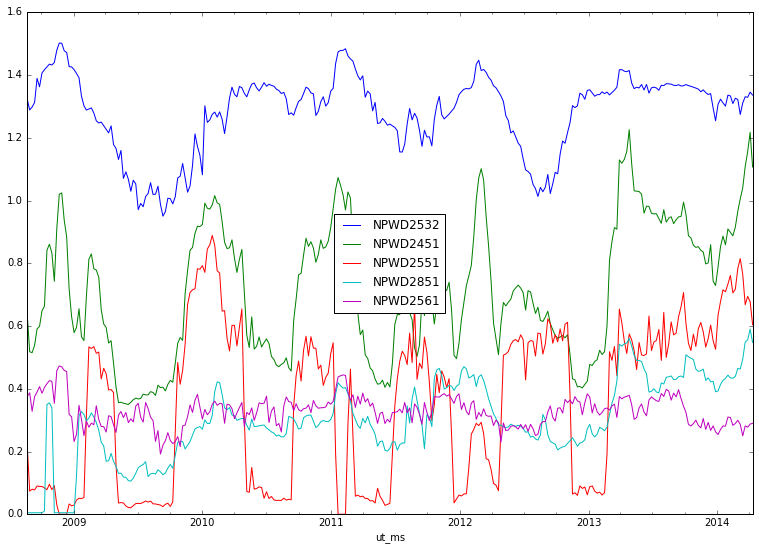

In [33]:
# for individual columns
col_scores = rate_columns(power_data)
power_data[[col for col, _ in col_scores[:5]]].resample("7D").mean().plot(figsize=(13, 9))

# sum totals
# power_data.sum(axis=1).resample("1D").mean().plot(figsize=(10, 7))
# longterm_data[["eclipseduration_min", "occultationduration_min"]].plot(figsize=(13, 9))

# power_data.sum(axis=1).resample("7D").mean().plot()

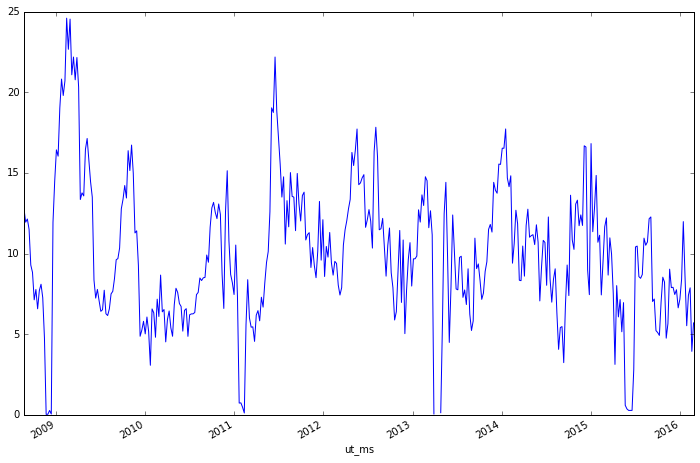

In [43]:
saa_data.sy.resample("7D").std().plot(figsize=(12, 8))


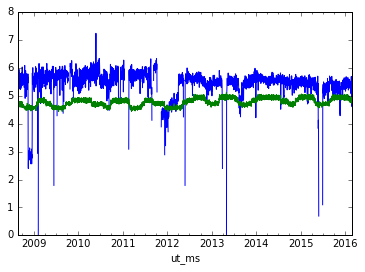

In [6]:
dmop_data["dummy"] = 1
numpy.log(dmop_data.dummy.resample("1D").count()).plot()

event_data["dummy"] = 1
numpy.log(event_data.dummy.resample("1D").count()).plot()
# dmop_data = dmop_data.pivot_table(index=dmop_data.index, columns="subsystem", values="dummy").resample("1D").count()

# column_variance = collections.Counter({col: dmop_data[col].std() for col in dmop_data.columns})
# print column_variance.most_common()
# for col, _ in column_variance.most_common()[:5]:
#     dmop_data[col].plot()

In [17]:
ftl_data[ftl_data.flagcomms].head(100)

def get_communications_periods(data):
    for row in data[data.flagcomms].itertuples():
        yield {"start": row[0], "end": row[1]}

fill_events(power_data, get_communications_periods(ftl_data), "flagcomms_true")
power_data.describe()

,NPWD2372,NPWD2401,NPWD2402,NPWD2451,NPWD2471,NPWD2472,NPWD2481,NPWD2482,NPWD2491,NPWD2501,...,NPWD2801,NPWD2802,NPWD2821,NPWD2851,NPWD2852,NPWD2871,NPWD2872,NPWD2881,NPWD2882,flagcomms_true
count,49125.000000,49125.000000,49125.000000,49125.000000,49125.000000,49125.000000,49125.000000,49125.000000,49125.000000,49125.000000,...,49125.000000,49125.000000,49125.000000,49125.000000,49125.000000,49125.000000,49125.000000,49125.000000,49125.000000,49464.000000
mean,0.127019,0.001916,0.175338,0.712670,0.000739,0.001243,0.002396,0.002253,0.201137,0.005294,...,0.001536,0.134522,0.005781,0.298668,0.000528,0.000522,0.000745,0.043995,0.003374,0.215692
std,0.039851,0.008065,0.001156,0.315429,0.000014,0.000581,0.022111,0.007616,0.053363,0.012247,...,0.000030,0.078641,0.000108,0.172007,0.000078,0.000011,0.000014,0.143814,0.000066,0.411306
min,0.001457,0.001411,0.034283,0.004949,0.000571,0.000613,0.000499,0.001462,0.001962,0.004884,...,0.001179,0.002123,0.004438,0.004733,0.000494,0.000479,0.000703,0.006134,0.003156,0.000000
25%,0.097174,0.001510,0.175089,0.454808,0.000731,0.000651,0.000566,0.001876,0.168675,0.005153,...,0.001519,0.071167,0.005724,0.157778,0.000521,0.000516,0.000738,0.006683,0.003342,0.000000
50%,0.121308,0.001529,0.175371,0.637445,0.000740,0.001140,0.000573,0.001899,0.198975,0.005215,...,0.001539,0.133861,0.005793,0.304358,0.000528,0.000523,0.000747,0.006765,0.003383,0.000000
75%,0.154155,0.001545,0.175606,0.972635,0.000747,0.001777,0.000578,0.001918,0.229163,0.005268,...,0.001555,0.186622,0.005852,0.395904,0.000534,0.000528,0.000754,0.006837,0.003416,0.000000
max,0.376517,0.267175,0.177803,2.175650,0.000857,0.006247,0.402500,0.306428,0.435523,1.965179,...,0.001769,0.324555,0.006287,1.146090,0.010409,0.000598,0.000857,0.723399,0.003873,1.000000


In [37]:
for name, c in ftl_data.type.value_counts().iteritems():
    print name, c

SLEW 27317
EARTH 20420
INERTIAL 7154
D4PNPO 3409
MAINTENANCE 2653
NADIR 2173
WARMUP 1261
ACROSS_TRACK 1033
RADIO_SCIENCE 690
D1PVMC 404
D9PSPO 148
D2PLND 114
SPECULAR 47
NADIR_LANDER 42
D3POCM 22
D7PLTS 16
SPOT 15
D8PLTP 6
D5PPHB 4


In [39]:
# create a 5-min sample index with start/end matching the main one
sample_index = pandas.DatetimeIndex(freq="5Min", start=power_data.index.min(), end=power_data.index.max())

def get_ftl_periods(ftl_slice):
    for row in ftl_slice.itertuples():
        yield {"start": row[0], "end": row[1]}

def get_event_series(datetime_index, event_ranges):
    series = pandas.Series(data=0, index=datetime_index, dtype=numpy.int8)

    for event in event_ranges:
        closest_start = series.index.searchsorted(event["start"], side="right")
        closest_end = series.index.searchsorted(event["end"], side="right")
        series.loc[closest_start:closest_end] = 1
    
    return series


# sample_series = pandas.Series(data=0, index=sample_index)
sample_df = pandas.DataFrame(index=sample_index)
sample_df["flagcomms"] = get_event_series(sample_df.index, get_ftl_periods(ftl_data[ftl_data.flagcomms]))
sample_df["flagcomms_60min"] = sample_df["flagcomms"].rolling(window=12).mean()

for name, count in ftl_data.type.value_counts().iteritems():
    if count > 100:
        sample_df[name] = get_event_series(sample_df.index, get_ftl_periods(ftl_data[ftl_data.type == name]))
        sample_df[name + "_60m"] = sample_df[name].rolling(window=12).mean()

sample_df.describe()

,flagcomms,flagcomms_60min,SLEW,SLEW_60m,EARTH,EARTH_60m,INERTIAL,INERTIAL_60m,D4PNPO,D4PNPO_60m,...,ACROSS_TRACK,ACROSS_TRACK_60m,RADIO_SCIENCE,RADIO_SCIENCE_60m,D1PVMC,D1PVMC_60m,D9PSPO,D9PSPO_60m,D2PLND,D2PLND_60m
count,593557.000000,593546.000000,593557.000000,593546.000000,593557.000000,593546.000000,593557.000000,593546.000000,593557.000000,593546.000000,...,593557.000000,593546.000000,593557.000000,593546.000000,593557.000000,593546.000000,593557.000000,593546.000000,593557.000000,593546.000000
mean,0.215922,0.215925,0.148481,0.148484,0.571851,0.571844,0.060237,0.060238,0.058326,0.058327,...,0.016047,0.016048,0.027896,0.027897,0.003991,0.003991,0.000886,0.000886,0.000352,0.000352
std,0.411461,0.377646,0.355577,0.195262,0.494811,0.419785,0.237925,0.171508,0.234360,0.196271,...,0.125658,0.101239,0.164676,0.150614,0.063050,0.043681,0.029756,0.024341,0.018761,0.012361
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.333333,0.000000,0.333333,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
dmop_data.isnull()

,subsystem,dummy
ut_ms,,
2008-08-22 00:00:11,False,False
2008-08-22 00:28:29,False,False
2008-08-22 00:28:34,False,False
2008-08-22 00:28:39,False,False
2008-08-22 00:28:44,False,False
2008-08-22 00:40:15,False,False
2008-08-22 00:47:15,False,False
2008-08-22 00:57:15,False,False
2008-08-22 01:09:41,False,False
